In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/train2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/train2014.zip
%cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
  
# download helper code
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/transformer.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/utils.py
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/vgg.py

# download style image  
!wget https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


[WinError 3] Impossibile trovare il percorso specificato: '/content/train'
C:\Users\Lorenzo\PycharmProjects\Visiope\Style_transfer\notebook
C:\Users\Lorenzo\PycharmProjects\Visiope\Style_transfer


"unzip" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [27]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg
import transformer
import utils
from tqdm import tqdm

In [18]:
cd notebook

C:\Users\Lorenzo\PycharmProjects\Visiope\Style_transfer\notebook


In [19]:
# GLOBAL SETTINGS
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "C:/Users/Lorenzo/PycharmProjects/Visiope/coco_data/train2017"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "C:/Users/Lorenzo/PycharmProjects/Visiope/Style_transfer/images/zero_1.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17
STYLE_WEIGHT = 50
TV_WEIGHT = 1e-6 
ADAM_LR = 0.001
SAVE_MODEL_PATH = "content/"
SAVE_IMAGE_PATH = "content/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35

========Epoch 1/2========


  0%|                                                                                                                                                        | 0/29572 [00:00<?, ?it/s]

========Iteration 1/29572========
	Content Loss:	3393610.00
	Style Loss:	22919238.00
	Total Loss:	26312848.00
Time elapsed:	5.137748718261719 seconds
Saved TransformerNetwork checkpoint file at content/checkpoint_0.pth


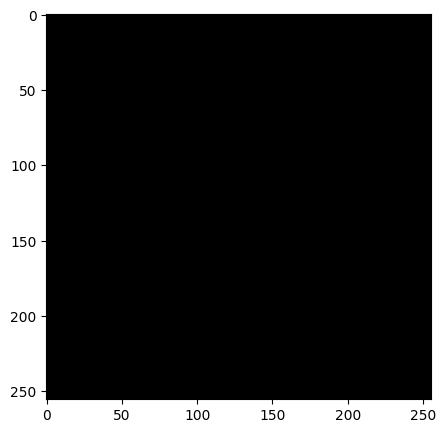

  0%|                                                                                                                                             | 1/29572 [00:05<43:31:03,  5.30s/it]

Saved sample tranformed image at content/sample0_0.png


  0%|                                                                                                                                             | 6/29572 [00:33<45:26:33,  5.53s/it]


KeyboardInterrupt: 

In [26]:
def train():
    # Seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Load networks
    TransformerNetwork = transformer.TransformerNetwork().to(device)
    VGG = vgg.VGG16('content/vgg16-00b39a1b.pth').to(device)

    # Get Style Features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    imagenet_mean = torch.tensor([103.939, 116.779, 123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    style_tensor = utils.itot(style_image).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    B, C, H, W = style_tensor.shape
    style_features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(TransformerNetwork.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()
    for epoch in range (1, NUM_EPOCHS+1):
        print("========Epoch {}/{}========".format(epoch, NUM_EPOCHS+1))
        for batch_id, (content_batch, _) in enumerate(tqdm(train_loader)):
            # Current Batch size in case of odd batches
            curr_batch_size = content_batch.shape[0]
            
            # Zero-out Gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = TransformerNetwork(content_batch)
            content_features = VGG(content_batch.add(imagenet_neg_mean))
            generated_features = VGG(generated_batch.add(imagenet_neg_mean))

            # Content Loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(content_features['relu2_2'], generated_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Style Loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss

            # Total Loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backprop and Weight Update
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(TransformerNetwork.state_dict(), checkpoint_path)
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0)
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)

            # Iterate Batch Counter
            batch_count+=1

    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    TransformerNetwork.eval()
    TransformerNetwork.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(TransformerNetwork.state_dict(), final_path)
    print("Done saving final model")

train()